In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
print(torch.__version__, torch.cuda.is_available())
# assert torch.__version__.startswith("1.7")

1.9.0+cu111 True


In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import matplotlib.pyplot as plt
import os, json, cv2, random
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [4]:
ROOT_DIR = "/data/train/"
# ANNO_PATH = "/home/sinan/datasets/instance_segm/train_coco_20210212"
train_json_file = os.path.join(ROOT_DIR,"coco/annotations.json")
train_img_dir = os.path.join(ROOT_DIR ,"processed/train")
# val
# ROOT_DIR_2 = "/home/sinan/datasets/instance_segm/val_coco_20210212/"
# ANNO_PATH_2 = "/home/sinan/datasets/instance_segm/val_coco_20210212"
# val_json_file = os.path.join(ANNO_PATH_2,"annotations.json") 
# val_img_dir = os.path.join(ROOT_DIR_2 ,"JPEGImages")

In [5]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("coco_val", {}, train_json_file, train_img_dir)
# register_coco_instances("coco_val", {}, val_json_file, val_img_dir)

In [6]:
# coco metadata info 
coco_metadata = MetadataCatalog.get("coco_val")

In [7]:
# dataset dictionary for visualization
dataset_dicts = DatasetCatalog.get("coco_val")

[07/08 11:19:26 d2.data.datasets.coco]: Loaded 1299 images in COCO format from /data/train/coco/annotations.json


In [9]:
def cv2_imshow(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10,10)), plt.imshow(im), plt.axis('off');

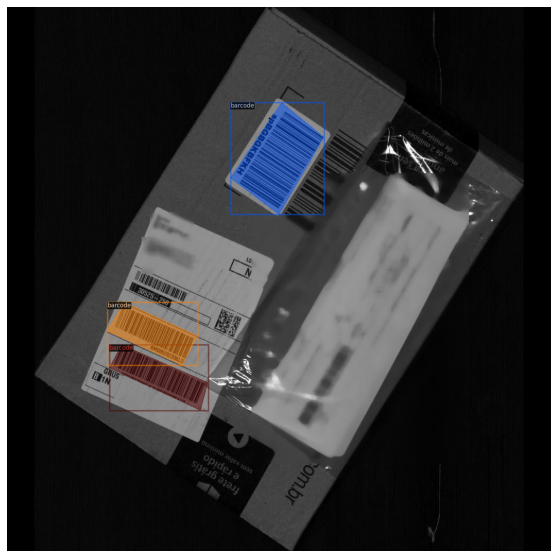

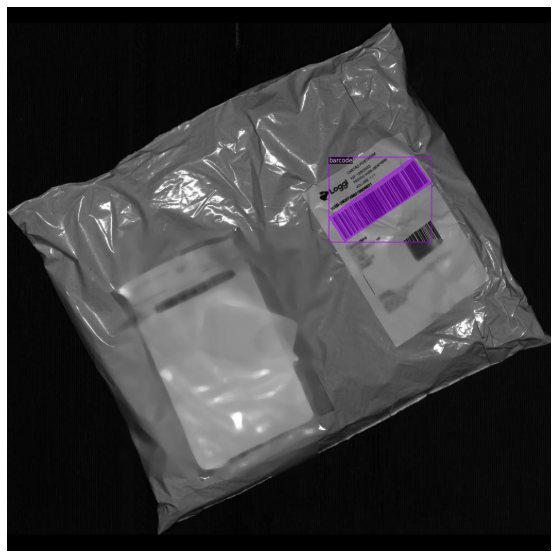

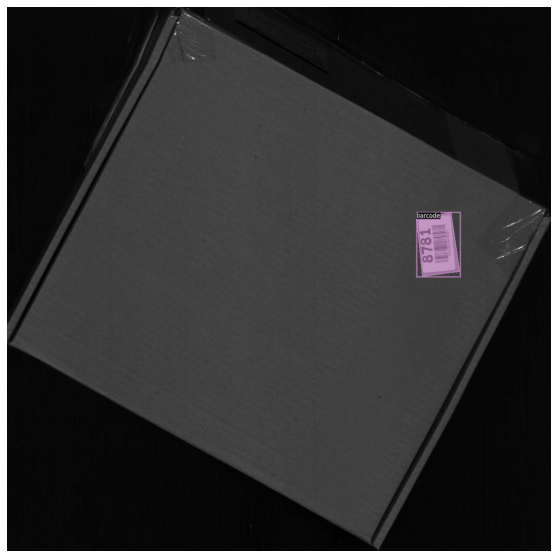

In [10]:
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=coco_metadata, scale=1.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [26]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("coco_val",)
# cfg.DATASETS.TEST = ("coco_val",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 1
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.TEST.EVAL_PERIOD = 1000
cfg.SOLVER.CHECKPOINT_PERIOD = 1000
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 2500 #100000 #10000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 32   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2 #3  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
cfg.INPUT.MIN_SIZE_TRAIN = (1024, 1024)
cfg.INPUT.MAX_SIZE_TRAIN = 1024
cfg.INPUT.MIN_SIZE_TEST = 1024
cfg.INPUT.MAX_SIZE_TEST = 1024

In [27]:
from datetime import datetime

In [28]:
#cfg.MODEL.DEVICE = "cpu"
out_dir = os.path.join("/versobin/output/", datetime.now().strftime("%Y%m%d-%H%M%S")+"_mask_rcnn_barcode")
cfg.OUTPUT_DIR = out_dir

In [29]:
cfg.OUTPUT_DIR 

'/versobin/output/20220708-121504_mask_rcnn_barcode'

In [30]:
# start training
trainer = DefaultTrainer(cfg)    #CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[07/08 12:15:36 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (2, 256, 1, 1) in

[07/08 12:15:37 d2.engine.train_loop]: Starting training from iteration 0
[07/08 12:15:48 d2.utils.events]:  eta: 0:22:55  iter: 19  total_loss: 2.325  loss_cls: 1.096  loss_box_reg: 0.4397  loss_mask: 0.6926  loss_rpn_cls: 0.06301  loss_rpn_loc: 0.01107  time: 0.5630  data_time: 0.0755  lr: 4.9953e-06  max_mem: 9079M
[07/08 12:16:00 d2.utils.events]:  eta: 0:23:05  iter: 39  total_loss: 2.258  loss_cls: 0.9906  loss_box_reg: 0.4512  loss_mask: 0.6897  loss_rpn_cls: 0.07518  loss_rpn_loc: 0.01037  time: 0.5742  data_time: 0.0687  lr: 9.9902e-06  max_mem: 9079M
[07/08 12:16:12 d2.utils.events]:  eta: 0:23:11  iter: 59  total_loss: 2.198  loss_cls: 0.8443  loss_box_reg: 0.5573  loss_mask: 0.684  loss_rpn_cls: 0.08413  loss_rpn_loc: 0.014  time: 0.5743  data_time: 0.0722  lr: 1.4985e-05  max_mem: 9079M
[07/08 12:16:23 d2.utils.events]:  eta: 0:23:02  iter: 79  total_loss: 2.025  loss_cls: 0.6941  loss_box_reg: 0.5831  loss_mask: 0.6718  loss_rpn_cls: 0.08118  loss_rpn_loc: 0.01469  time: 

In [31]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
#cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [32]:
# create visualization directory
save_dir =cfg.OUTPUT_DIR + "/test_vis"
if not os.path.exists(save_dir):
    os.makedirs(save_dir,exist_ok=True)

In [33]:
for each_image in dataset_dicts[:100]:
    # print(each_image['file_name'])
    #pedict
    im = cv2.imread(each_image['file_name'])
    outputs = predictor(im)
    v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
#     cv2_imshow(out.get_image()[:, :, ::-1])
    #save
    cv2.imwrite(os.path.join(save_dir,os.path.basename(each_image['file_name'])),out.get_image()[:, :, ::-1])

In [ ]:
# validation_folder = Path(val_img_dir)
# output_dir = ROOT_DIR_2+"/test_vis_20210128_02/"
# print(output_dir)
# os.mkdir(output_dir)

# for i, file in enumerate(validation_folder.glob("*.png")):
#     # this loop opens the .jpg files from the val-folder, creates a dict with the file
#     # information, plots visualizations and saves the result as .pkl files.
#     file = str(file)
#     file_name = file.split("/")[-1]
#     img = cv2.imread(file)
#     #outputs
#     outputs = predictor(img)
#     v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
#     out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
#     save_name = os.path.join(output_dir,file_name)
#     cv2.imwrite(save_name,out.get_image()[:, :, ::-1])

In [34]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
# another equivalent way to evaluate the model is to use `trainer.test`
#cfg.DATASETS.TEST = ("coco_train")

In [35]:
evaluator = COCOEvaluator("coco_val", ("bbox", "segm"), False, output_dir=cfg.OUTPUT_DIR )
val_loader = build_detection_test_loader(cfg, "coco_val")
print(inference_on_dataset(trainer.model, val_loader, evaluator))

[07/08 12:46:00 d2.data.datasets.coco]: Loaded 1299 images in COCO format from /data/train/coco/annotations.json
[07/08 12:46:00 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(1024, 1024), max_size=1024, sample_style='choice')]
[07/08 12:46:00 d2.data.common]: Serializing 1299 elements to byte tensors and concatenating them all ...
[07/08 12:46:00 d2.data.common]: Serialized dataset takes 6.10 MiB
[07/08 12:46:00 d2.evaluation.evaluator]: Start inference on 1299 batches
[07/08 12:46:01 d2.evaluation.evaluator]: Inference done 11/1299. Dataloading: 0.0013 s/iter. Inference: 0.0669 s/iter. Eval: 0.0089 s/iter. Total: 0.0770 s/iter. ETA=0:01:39
[07/08 12:46:06 d2.evaluation.evaluator]: Inference done 75/1299. Dataloading: 0.0015 s/iter. Inference: 0.0667 s/iter. Eval: 0.0105 s/iter. Total: 0.0787 s/iter. ETA=0:01:36
[07/08 12:46:11 d2.evaluation.evaluator]: Inference done 138/1299. Dataloading: 0.0018 s/iter. Inference: 0.0